# Dataset : FER2013

# Import required packages and read images from data path

In [2]:
import numpy as np 
import pandas as pd
import seaborn as sns

import os, random
for dirname, _, filenames in os.walk('../project/FER2013'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../project/FER2013\test\angry\PrivateTest_10131363.jpg
../project/FER2013\test\angry\PrivateTest_10304478.jpg
../project/FER2013\test\angry\PrivateTest_1054527.jpg
../project/FER2013\test\angry\PrivateTest_10590091.jpg
../project/FER2013\test\angry\PrivateTest_1109992.jpg
../project/FER2013\test\angry\PrivateTest_11296953.jpg
../project/FER2013\test\angry\PrivateTest_12000629.jpg
../project/FER2013\test\angry\PrivateTest_12008383.jpg
../project/FER2013\test\angry\PrivateTest_12191716.jpg
../project/FER2013\test\angry\PrivateTest_1221822.jpg
../project/FER2013\test\angry\PrivateTest_12403575.jpg
../project/FER2013\test\angry\PrivateTest_12766285.jpg
../project/FER2013\test\angry\PrivateTest_12846357.jpg
../project/FER2013\test\angry\PrivateTest_1290484.jpg
../project/FER2013\test\angry\PrivateTest_12912780.jpg
../project/FER2013\test\angry\PrivateTest_13164119.jpg
../project/FER2013\test\angry\PrivateTest_13278552.jpg
../project/FER2013\test\angry\PrivateTest_13463625.jpg
../project/FER

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [4]:
train_dir = '../project/FER2013/train'
test_dir = '../project/FER2013/test'

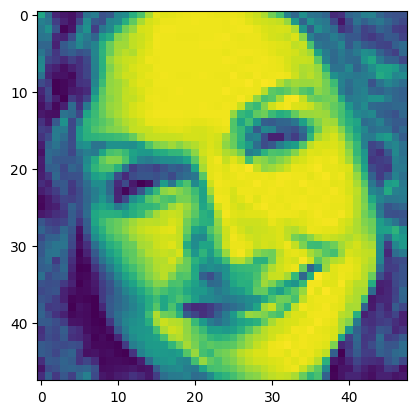

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
img = image.load_img('../project/FER2013/train/happy/Training_10181727.jpg', target_size=(48,48), color_mode='grayscale')
plt.imshow(img)

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_gen = ImageDataGenerator(rotation_range=20,
                              rescale=1./255,
                              shear_range=0.1,
                              zoom_range=0.2,
                              horizontal_flip=True,
                              width_shift_range=0.1,
                              height_shift_range=0.1)

training_data = train_gen.flow_from_directory(train_dir,
                                             target_size=(96,96),
                                             batch_size=32,
                                             color_mode = "rgb",
                                             class_mode = "categorical")

Found 28709 images belonging to 7 classes.


In [7]:
valid_gen = ImageDataGenerator(rescale=1./255)

valid_data = valid_gen.flow_from_directory(test_dir,
                                          target_size=(96,96),
                                          batch_size=50,
                                          color_mode='rgb',
                                          class_mode='categorical')

Found 7178 images belonging to 7 classes.


# Model Building

In [8]:
from tensorflow.keras.applications.vgg19 import VGG19

vgg = VGG19(weights='imagenet', include_top=False)

for layer in vgg.layers:
    layer.trainable = False

In [9]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model

input = Input(shape=(96,96,3))

conv = Conv2D(3, kernel_size=(3,3), padding='same')(input)

vgg = vgg(conv)
    
x = Flatten()(vgg)

pred = Dense(7, activation='softmax')(x)

model = Model(inputs=input, outputs=pred)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 3)         84        
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 7)                 32263     
                                                                 
Total params: 20,056,731
Trainable params: 32,347
Non-trainable params: 20,024,384
_________________________________________________________________


In [11]:
#EVALUATION

import keras.backend as K
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [12]:
#EVALUATION

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
      f1_score,
]

In [13]:
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.0001)

model.compile(optimizer = opt,
              loss='categorical_crossentropy',
              metrics=METRICS
)

In [14]:
from keras import callbacks
filepath="Best1.hdf5"
checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss',save_best_only=True, mode='min')
callbacks_list = [checkpoint]
history = model.fit(training_data, epochs=50,callbacks=callbacks_list, validation_data = valid_data)

Epoch 1/50
898/898 [==============================] - 115s 117ms/step - loss: 1.7006 - accuracy: 0.8586 - precision: 0.6497 - recall: 0.0214 - auc: 0.7176 - f1_score: 0.0394 - val_loss: 1.6113 - val_accuracy: 0.8639 - val_precision: 0.5956 - val_recall: 0.1484 - val_auc: 0.7581 - val_f1_score: 0.2355
Epoch 2/50
898/898 [==============================] - 101s 112ms/step - loss: 1.5785 - accuracy: 0.8633 - precision: 0.6691 - recall: 0.0847 - auc: 0.7715 - f1_score: 0.1470 - val_loss: 1.5472 - val_accuracy: 0.8675 - val_precision: 0.6324 - val_recall: 0.1730 - val_auc: 0.7811 - val_f1_score: 0.2699
Epoch 3/50
898/898 [==============================] - 101s 112ms/step - loss: 1.5245 - accuracy: 0.8668 - precision: 0.6874 - recall: 0.1234 - auc: 0.7904 - f1_score: 0.2052 - val_loss: 1.4732 - val_accuracy: 0.8710 - val_precision: 0.6987 - val_recall: 0.1709 - val_auc: 0.8054 - val_f1_score: 0.2717
Epoch 4/50
898/898 [==============================] - 101s 112ms/step - loss: 1.4912 - accurac

# Qualitative Evaluation

1/1 [==============================] - 0s 18ms/step


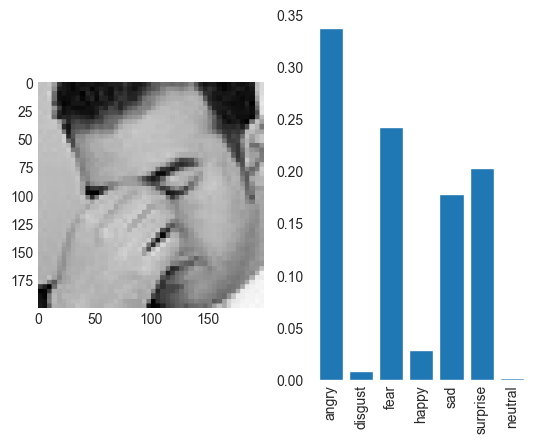

Expression Prediction: angry
1/1 [==============================] - 0s 16ms/step


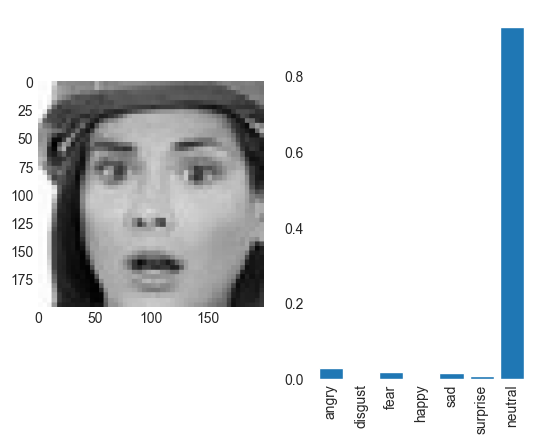

Expression Prediction: neutral
1/1 [==============================] - 0s 17ms/step


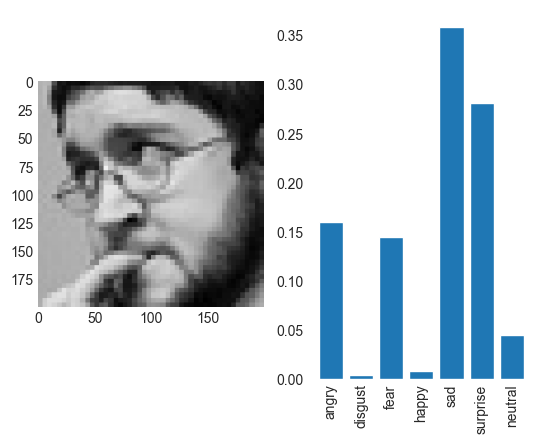

Expression Prediction: sad
1/1 [==============================] - 0s 16ms/step


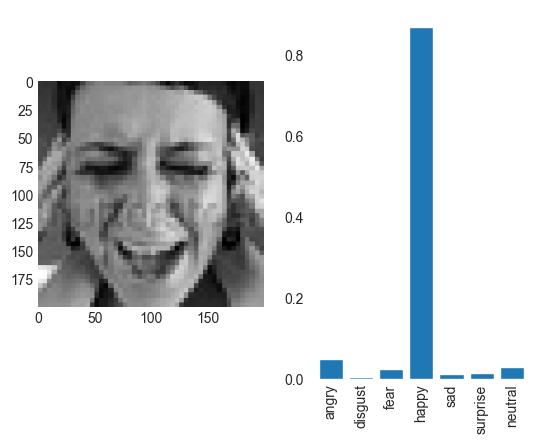

Expression Prediction: happy
1/1 [==============================] - 0s 17ms/step


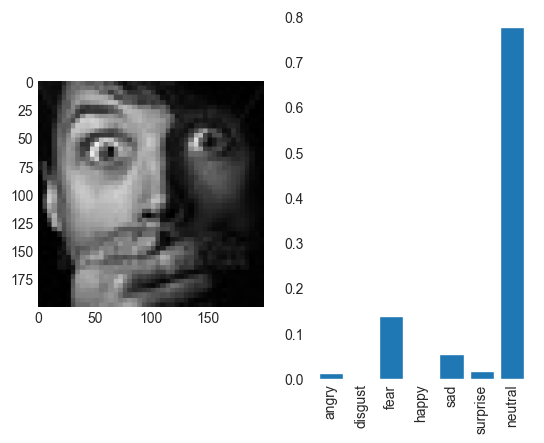

Expression Prediction: neutral
1/1 [==============================] - 0s 17ms/step


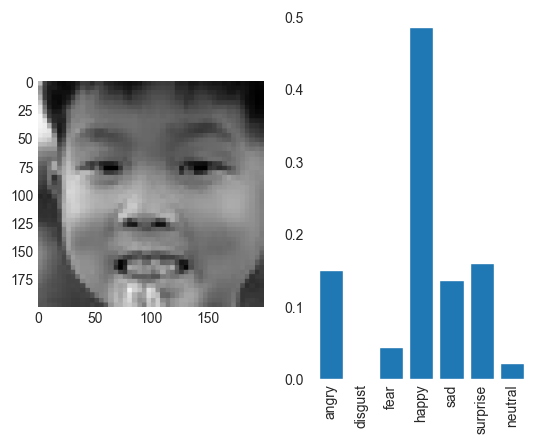

Expression Prediction: happy
1/1 [==============================] - 0s 17ms/step


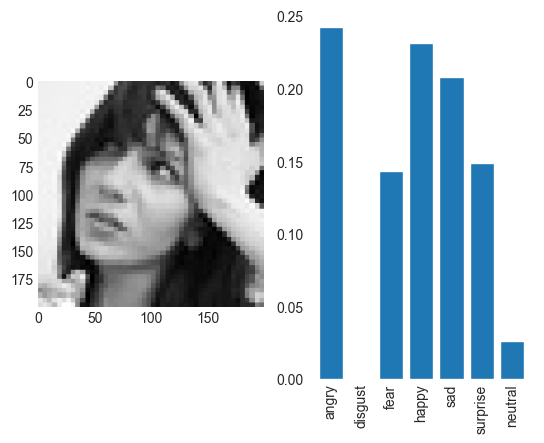

Expression Prediction: angry
1/1 [==============================] - 0s 16ms/step


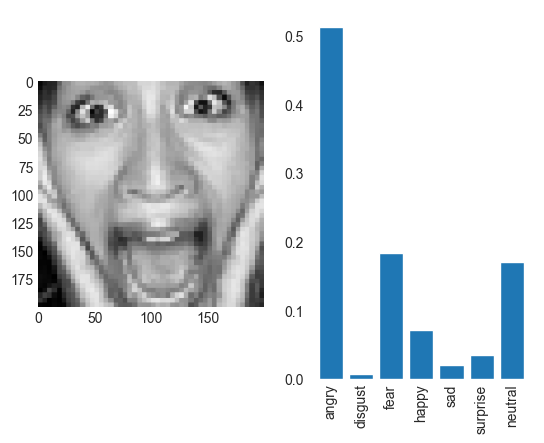

Expression Prediction: angry
1/1 [==============================] - 0s 18ms/step


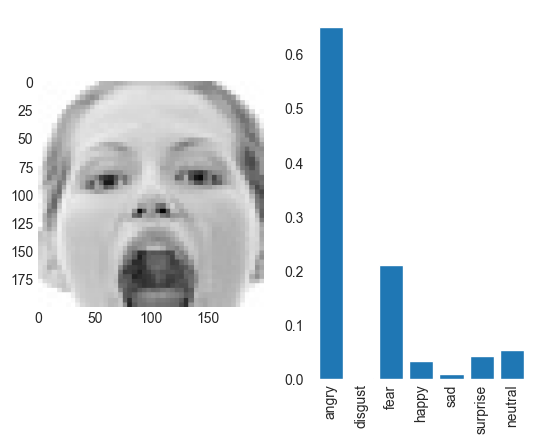

Expression Prediction: angry
1/1 [==============================] - 0s 17ms/step


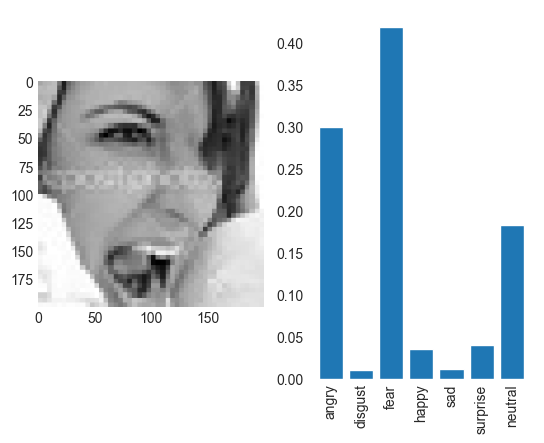

Expression Prediction: fear


In [33]:
objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
for i in range(0, 10):
    randimg = random.choice(os.listdir("../project/FER2013/test/fear/"))
    randimgpath = "../project/FER2013/test/fear/" + randimg
    img = image.load_img(randimgpath, target_size = (96, 96))
    show_img = image.load_img(randimgpath, target_size = (200, 200))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)

    x /= 255

    custom = model.predict(x)

    x = np.array(x, 'float32')
    x = x.reshape([96, 96, 3]);

    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.gray()
    plt.subplot(1,2,1)
    plt.imshow(show_img)
    
    plt.subplot(1,2,2)
    plt.bar(objects,custom[0])
    plt.xticks(rotation=90)
    
    plt.show()

    a = custom[0]
    m = a[0]
    for i in range(0,len(a)):
        if a[i] >= m:
            m = a[i]
            ind = i

    print('Expression Prediction:',objects[ind])

# Quantitative Evaluation

In [17]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_auc = history.history['auc']
val_auc = history.history['val_auc']

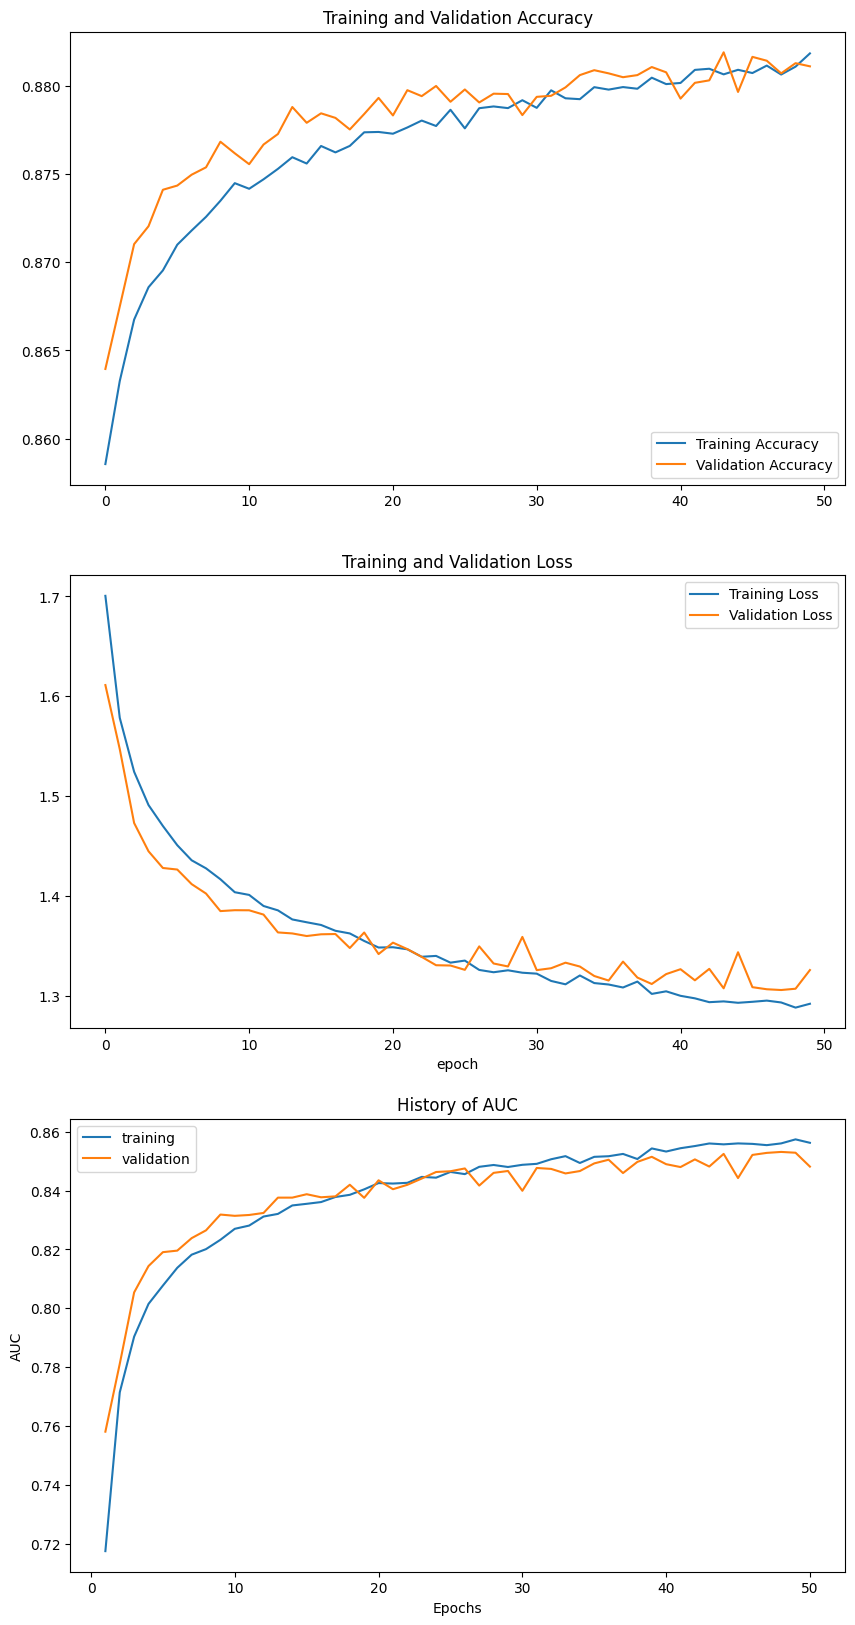

In [18]:
epochs_range = range(len(train_acc))

plt.figure(figsize=(10, 20))
plt.subplot(3, 1, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(3, 1, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.subplot(3, 1, 3)
plt.plot(range(1, len(train_auc) + 1), train_auc)
plt.plot(range(1, len(val_auc) + 1), val_auc)
plt.title('History of AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend(['training', 'validation'])
plt.show()

In [19]:
#EVALUATION

print('Train Accuracy: ', round(history.history['accuracy'][-1],2))
print('Train Loss: ', round(history.history['loss'][-1],2))
print('Train Precision: ', round(history.history['precision'][-1],2))
print('Train Recall: ', round(history.history['recall'][-1],2))
print('Train F1-Score: ', round(history.history['f1_score'][-1],2))

Train Accuracy:  0.88
Train Loss:  1.29
Train Precision:  0.71
Train Recall:  0.29
Train F1-Score:  0.41


In [20]:
#EVALUATION

print('Test Accuracy: ', round(history.history['val_accuracy'][-1],2))
print('Test Loss: ', round(history.history['val_loss'][-1],2))
print('Test Precision: ', round(history.history['val_precision'][-1],2))
print('Test Recall: ', round(history.history['val_recall'][-1],2))
print('Test F1-Score: ', round(history.history['val_f1_score'][-1],2))

Test Accuracy:  0.88
Test Loss:  1.33
Test Precision:  0.67
Test Recall:  0.33
Test F1-Score:  0.44


# Confusion matrix

In [30]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap='viridis'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [31]:
y_true = valid_data.classes
y_hat =  model.predict(valid_data)
y_hat = tf.argmax(y_hat, axis = 1).numpy()
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

144/144 [==============================] - 9s 63ms/step


Confusion matrix, without normalization
[[144   0  37 325 222 122 108]
 [ 14   1   5  35  25  13  18]
 [168   2  38 336 221 142 117]
 [266   7  74 622 389 214 202]
 [191   3  52 408 276 153 150]
 [200   3  52 433 247 155 157]
 [120   4  28 268 194  91 126]]


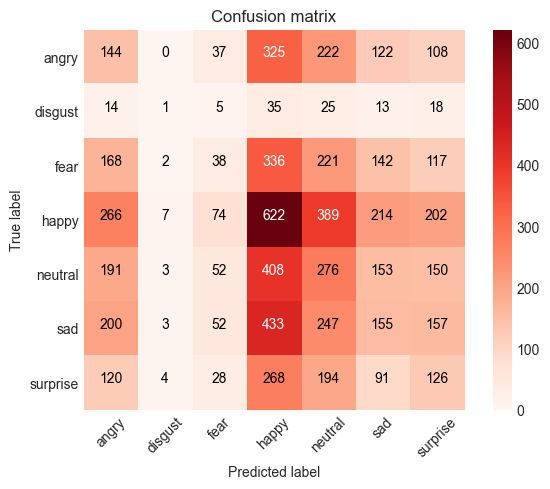

In [32]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true = y_true, y_pred = y_hat)
plot_confusion_matrix(cm, classes, cmap = 'Reds')
plt.savefig('confmat.png')